# Import the library

In [45]:
# import basic math and data ETL library
import numpy as np 
import pandas as pd 

# import visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import statistics library
import statsmodels
from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm, boxcox
from scipy.special import boxcox1p

# Import the data 

In [2]:
PATH_CITY_DAY = "data/air-quality-data-in-india/city_day.csv"
df_city_day = pd.read_csv(PATH_CITY_DAY, parse_dates=True)

# Choose city 'DELHI'
CITY = ["Delhi"]
df = df_city_day[df_city_day.City.isin(CITY)]

**We select only city 'DELHI' so we have to reset the index to start it from 0 not from some random high number.** 

In [3]:
df = df.reset_index(drop=True)

# Lets meet with our data!!

In [4]:
# Check shape, info and describe
df.shape

(2009, 16)

In [5]:
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
1,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
2,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
3,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
4,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [6]:
# City is same all over dataset so we drop City column
df.drop('City', axis=1, inplace=True)

**Observation:**
1. There seems to be lot of difference between 75% data and maximium value in most of the columns.
2. Also there is much difference between the range of minimium and maximium value. Shows Skewness.

In [7]:
df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,2007.000000,1932.000000,2007.000000,2007.000000,2009.000000,2000.000000,2009.000000,1899.000000,1925.00000,2009.000000,2009.000000,1228.000000,1999.000000
mean,117.196153,232.809229,38.985595,50.785182,58.567023,41.997150,1.976053,15.901253,51.32361,3.544480,17.185042,1.438339,259.487744
std,82.912945,121.873025,33.389456,22.696721,37.690350,17.301221,2.560253,7.966770,26.06234,2.431232,15.291597,2.377762,119.537333
min,10.240000,18.590000,3.570000,10.630000,0.000000,6.780000,0.000000,2.340000,6.94000,0.000000,0.000000,0.000000,29.000000
25%,57.095000,137.040000,15.895000,33.895000,31.150000,31.157500,0.910000,10.335000,33.71000,1.870000,6.650000,0.110000,161.500000
50%,94.620000,216.730000,27.200000,47.150000,52.750000,38.040000,1.240000,14.450000,44.44000,2.960000,12.750000,0.650000,257.000000
75%,153.030000,311.667500,50.790000,63.570000,75.360000,48.792500,1.870000,19.700000,60.84000,4.680000,23.200000,1.970000,345.500000
max,685.360000,796.880000,221.030000,162.500000,254.800000,166.700000,30.440000,71.560000,257.73000,20.640000,103.000000,23.300000,716.000000


**As we can see there is some missing data in our dataframe.**
* Xylene seems to be a lot of missing values
* PM2.5, NO, NO2 are missing the same number of values.
* PM10 and O3 have also some missing data.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2009 non-null   object 
 1   PM2.5       2007 non-null   float64
 2   PM10        1932 non-null   float64
 3   NO          2007 non-null   float64
 4   NO2         2007 non-null   float64
 5   NOx         2009 non-null   float64
 6   NH3         2000 non-null   float64
 7   CO          2009 non-null   float64
 8   SO2         1899 non-null   float64
 9   O3          1925 non-null   float64
 10  Benzene     2009 non-null   float64
 11  Toluene     2009 non-null   float64
 12  Xylene      1228 non-null   float64
 13  AQI         1999 non-null   float64
 14  AQI_Bucket  1999 non-null   object 
dtypes: float64(13), object(2)
memory usage: 235.6+ KB


# Its Analysis time!!
We are gonna start with our old trusted correlation table. Ofcourse, We take help from our friend pandas and for stunning visualization. 
Seaborn and matplotlib are here to save us from long lines of code.
#### Observations:
* PM2.5, PM10 are very strongly correlated with AQI which makes sense because particulate matter(PM) includes microscopic matter suspended in air. They can be emitted directly into the air from industry, residential, agriculture, transport activities.
* Nitrides (NO, NO2, NOx) and Benzene are also strongly correlated, not on PM level, with AQI. (I can smell new feature here).
* carbon monoxide (CO), toulene and Xylene are not so strongly correlated with AQI.

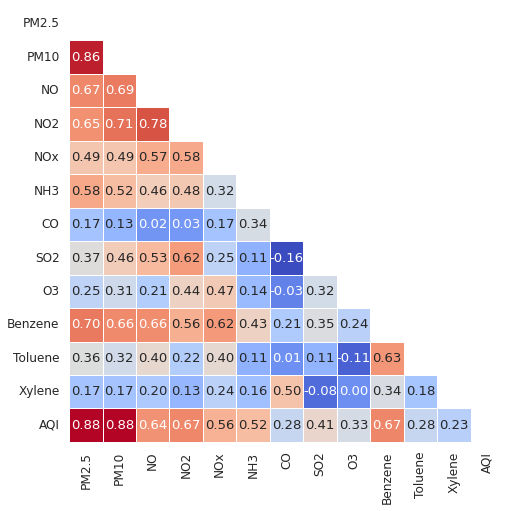

In [9]:
# Display numerical correlations (pearson) between features on heatmap.
# Seaborn does all the heavy-lifting for us.
# Matplotlib does all the heavy-lifting for seaborn eventually for us.

sns.set(font_scale=1.1, style='whitegrid')
mask = np.triu(np.ones_like(df.corr(), dtype=bool)) #Why make full when half is enough.
plt.figure(figsize=(10, 8))
sns.heatmap(
            df.corr(), 
            annot = True,
            square = True,
            fmt='.2f',
            mask = mask,
            cmap = 'coolwarm',
            linewidths=1,
            cbar = False
            );

# No more missing for Missing Values. Lets find out.

In [10]:
# Lets make a pact: Always make function when you are gonna write same code over and over.
# Read zen of python by Tim Peters or "import this"

def missing_values_and_percentage(df):
    all_the_missing_values = df.isnull().sum().sort_values(ascending=False)
    total_missing_values = all_the_missing_values[df.isnull().sum() != 0]
    percentage = (all_the_missing_values / len(df) * 100)[df.isnull().sum() != 0]
    return pd.concat([total_missing_values, percentage], axis=1, keys=['Total', 'Percent'])

In [11]:
# Now call your function
missing_values_and_percentage(df)
# See it answers
# you wanna make it horizontal use missing_values_and_percentage(df).T

,Total,Percent
Xylene,781,38.875062
SO2,110,5.475361
O3,84,4.181185
PM10,77,3.832753
AQI,10,0.497760
AQI_Bucket,10,0.497760
NH3,9,0.447984
PM2.5,2,0.099552
NO,2,0.099552
NO2,2,0.099552


#### Missing Values Observations:
* Xylene beats everyone but to calculate AQI Xylene is not necessary. So it makes sense.
* PM2.5, NO, NO2 are missing the same number of values(2).
* PM10 and O3 have also some missing data.

,Xylene,SO2,O3,PM10,AQI,AQI_Bucket,NH3,PM2.5,NO,NO2
Total,781.000000,110.000000,84.000000,77.000000,10.000000,10.000000,9.000000,2.000000,2.000000,2.000000
Percent,38.875062,5.475361,4.181185,3.832753,0.497760,0.497760,0.447984,0.099552,0.099552,0.099552


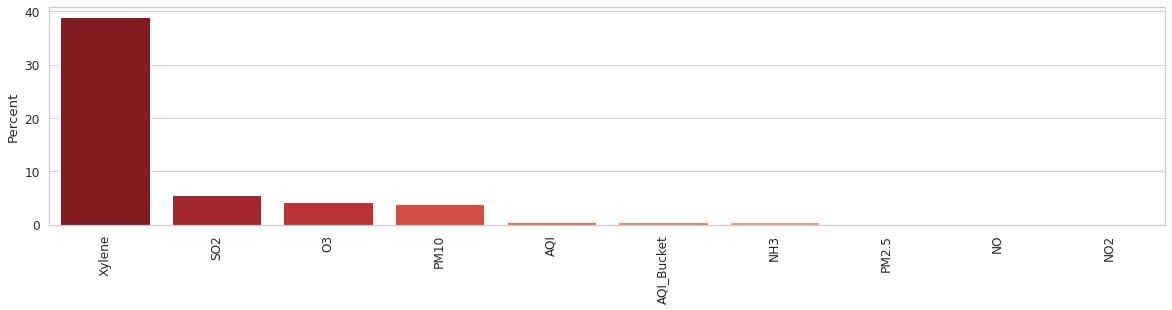

In [12]:
# Lets be honest DataFrame gives us all the information we needed but who doesnt wanna see visualization.
# Bring out your magic sticks and say with me Abracadabra 
missing = missing_values_and_percentage(df)

fig, ax = plt.subplots(figsize=(20, 4))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

# Seems like dataframe wanna look too gradienty (Like its real word, Wait it may be a cool website..)
display(missing.T.style.background_gradient(cmap='Reds', axis=1))

## Ok time to find our missing data 🔍:
* We can fill "forward fill" for NO, NO2, PM2.5, O3, SO2, PM10 and NH3.
* For AQI we cant use mean but median is up for the job.
* According to AQI we can fill AQI_Bucket.
* Xylene has lot of missing values for now drop Xylene. See ya Xylene.

In [13]:
# I know I know we dont make mistakes but prevention is better than cure.
df_copy = df.copy()

In [14]:
# First is Backward filling.

df_copy['PM2.5'] = df_copy['PM2.5'].fillna(method='bfill')
df_copy['NO'] = df_copy['NO'].fillna(method='bfill')
df_copy['NO2'] = df_copy['NO2'].fillna(method='bfill')
df_copy['NH3'] = df_copy['NH3'].fillna(method='bfill')
df_copy['O3'] = df_copy['O3'].fillna(method='bfill')
df_copy['SO2'] = df_copy['SO2'].fillna(method='bfill')
df_copy['PM10'] = df_copy['PM10'].fillna(method='bfill')
df_copy['Xylene'] = df_copy['Xylene'].fillna(method='bfill')

# Yupe, you guess it right median is always on mid(only for even length).
df_copy['AQI'] = df_copy['AQI'].fillna(df_copy['AQI'].median())

# Xylene our journey ends here.
# df_copy.drop('Xylene', axis=1, inplace=True) #use inplace carefully.

# Feature Engineering
Ok so lets dig deep and find out more of our data. There are no missing values so we're good to go! (Just for a second feels like I am forgetting something!!)

## Categorical Data
From the moment we started we are busy with numeric data, categorical value(s) are feeling left out. As a good data analyst and scientist we must not leave our data behind. Boxplots seems decent way to inspect this type of relation.

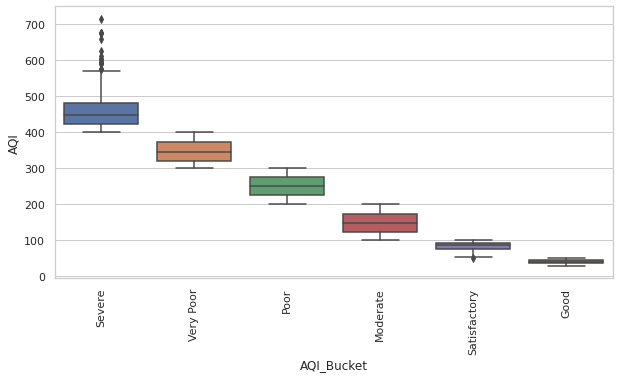

In [15]:
# So lets box it up..
# There is only one categorical value but that doesnt stop us.
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
order = df_copy.groupby(['AQI_Bucket'])['AQI'].median().sort_values(ascending=False)
sns.boxplot(data=df_copy, x='AQI_Bucket', y='AQI', order=order.index)
plt.xticks(rotation=90);

**we can see very clear relationship between AQI and AQI_Bucket, Today is our lucky day or what..wait no no we are not lucky its just showing there are 6 divided classes.**</br>
{</br>
under 100: Good and Satisfactory,</br>
Between 100 and 200: Moderate,</br>
Between 200 and 300: Poor,</br>
Between 300 and 400: Very Poor,</br>
Above 400: Severe,</br>
}</br>
***As we can see there are out-liars above 580 AQI in severe class.***

**You think I forget about missing values in AQI_Bucket, Its time to fill our bucket.**

In [16]:
#  Take help of AQI.median() and yes, we get result: Poor, nothing new here. lets fill our bucket
df_copy['AQI_Bucket'].replace(np.nan, 'Poor', inplace=True)

# Numeric Data
**Observations:**
* As PM2.5 and PM10 increases overall AQI increases. This confirms the correlation in first table we did at the beginning. (Pearson corr was 0.8)
* Nitrides(NO, NO2, NOx) also support this but NO has exponential relationship.
* All data shows some clear outliers after high ranges ( CO, NH3, NO2, NOx, SO2, O3, Benzene and Toulene)
* Green helps CO why high value is this anamoly or what?

In [17]:
sns.set(style="white")
def plot_scatter(y, df):
    
    '''A function for displaying categorical variables.'''
    
    fig, axes = plt.subplots(3, 4, figsize=(25, 15))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.scatterplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    color='#e74c3c',
                    )
        j.tick_params(labelrotation=45)
        
        plt.tight_layout()

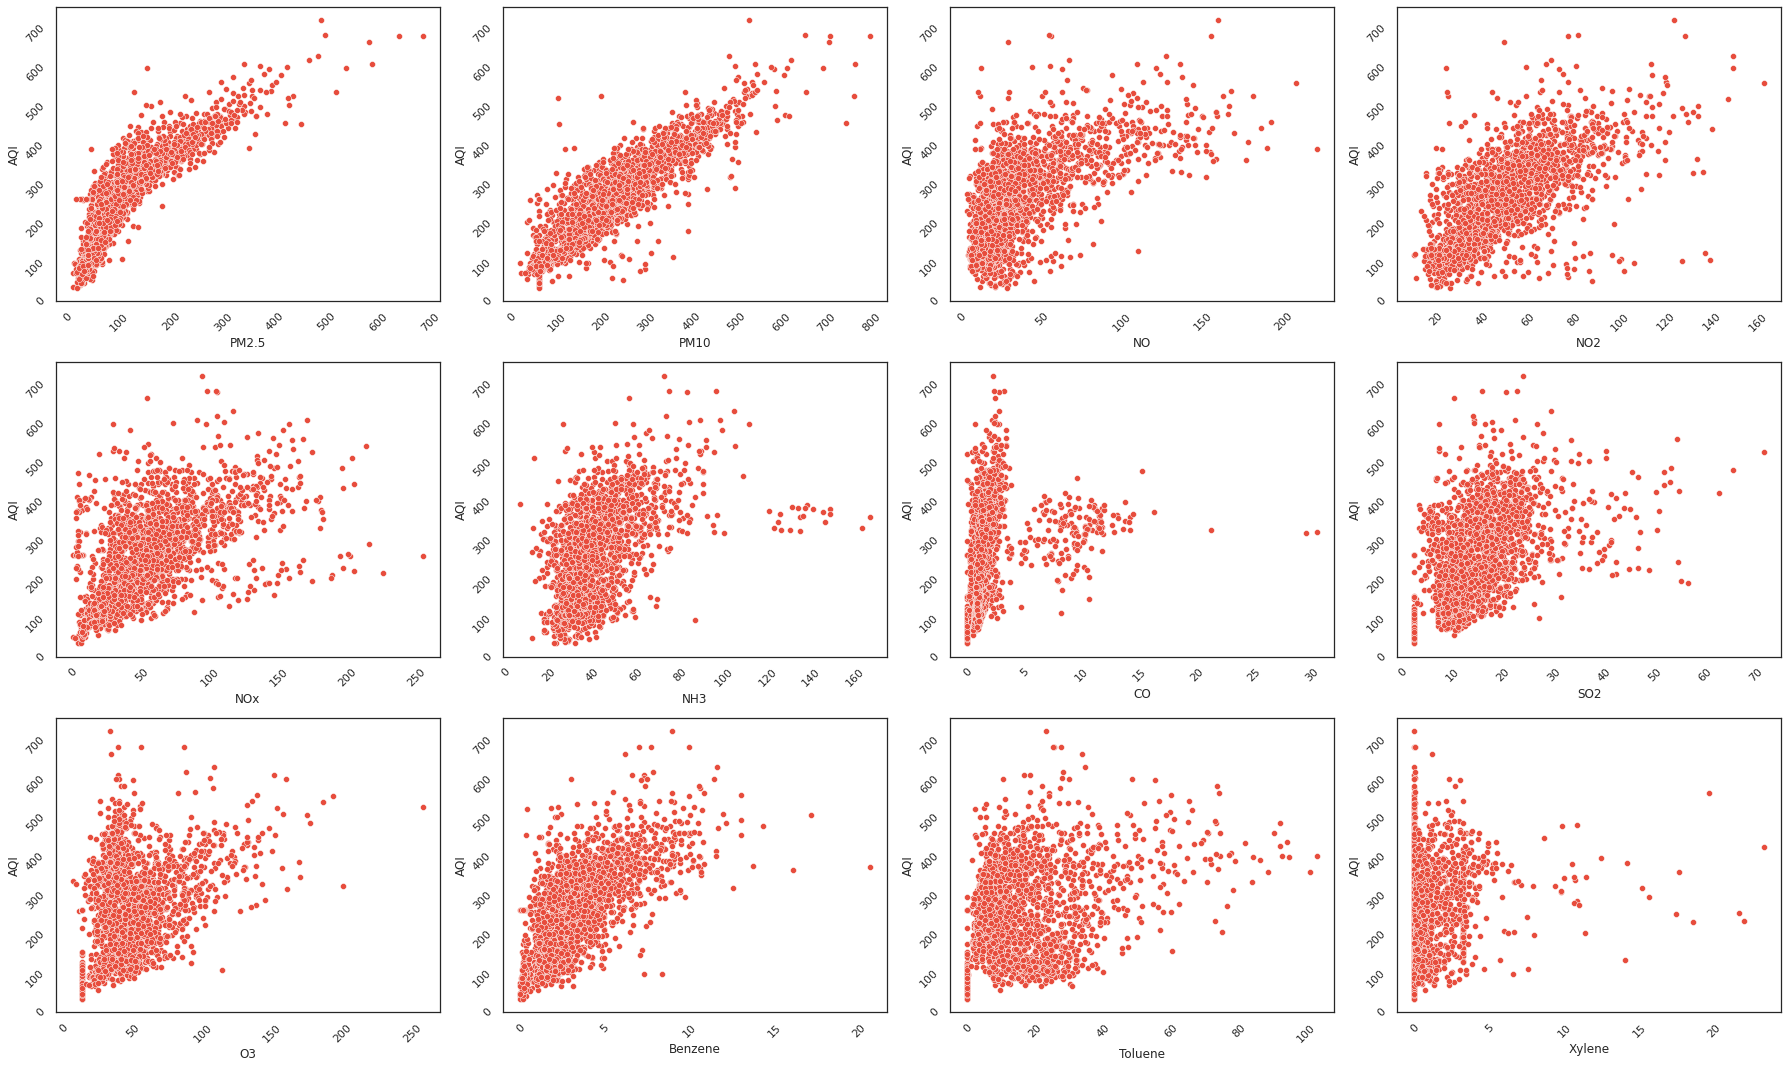

In [18]:
plot_scatter('AQI', df_copy)

**We can see some clear outliers after 600 AQI in AQI.**

## Outliers
We're going to drop some outliers we detected just above, You can try different approaches.

In [19]:
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] > 500) & (df_copy['PM2.5'] > 480)].index)
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] > 500) & (df_copy['PM10'] > 600) | (df_copy['PM10'] > 700)].index)
df_copy = df_copy.drop(df_copy[(df_copy['NO'] > 170)].index)
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] < 200) & (df_copy['NO2'] > 100)].index)
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] < 300) & (df_copy['NOx'] > 180)].index)
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] > 400) & (df_copy['NH3'] > 140)].index)
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] < 400) & (df_copy['CO'] > 20)].index)
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] < 600) & (df_copy['SO2'] > 60)].index)
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] < 600) & (df_copy['O3'] > 200)].index)
df_copy = df_copy.drop(df_copy[(df_copy['AQI'] < 600) & (df_copy['Benzene'] > 15)].index)
df_copy = df_copy.drop(df_copy[(df_copy['Xylene'] > 15)].index)

df_copy.reset_index(drop=True, inplace=True)

## Creating new features

In [20]:
df_copy['PM'] = df_copy['PM2.5'] + df_copy['PM10']

#clubbing nitrogen oxides
df_copy['Nitric'] = df_copy['NO'] + df_copy['NO2']+ df_copy['NOx']

#clubbing Benzene, toluene and Xylene together
df_copy['BTX'] = df_copy['Benzene'] + df_copy['Toluene']+ df_copy['Xylene']

# df_copy.drop(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'Benzene', 'Toluene', 'Xylene'], axis=1, inplace=True)



In [21]:
X = df_copy.drop('AQI', axis=1)
y = df_copy['AQI']

In [26]:
df_copy

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,PM,Nitric,BTX
0,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe,921.20,216.14,49.06
1,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe,455.73,183.10,34.93
2,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate,219.08,103.99,16.13
3,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor,393.68,110.54,17.31
4,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor,365.73,87.18,11.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,2020-06-27,39.80,155.94,10.88,21.46,22.47,31.43,0.87,10.38,18.88,1.69,19.99,0.43,112.0,Moderate,195.74,54.81,22.11
1948,2020-06-28,59.52,308.65,12.67,21.60,23.86,29.27,0.94,10.70,18.05,1.71,25.13,1.74,196.0,Moderate,368.17,58.13,28.58
1949,2020-06-29,44.86,184.12,10.50,21.57,21.94,27.97,0.88,11.58,26.61,2.13,23.80,1.13,233.0,Poor,228.98,54.01,27.06
1950,2020-06-30,39.80,91.98,5.99,17.96,15.44,28.48,0.84,10.51,37.29,1.57,16.37,0.49,114.0,Moderate,131.78,39.39,18.43


In [27]:
df_copy.index = df_copy['Date']

In [28]:
df_copy.drop('Date', axis=1, inplace=True)

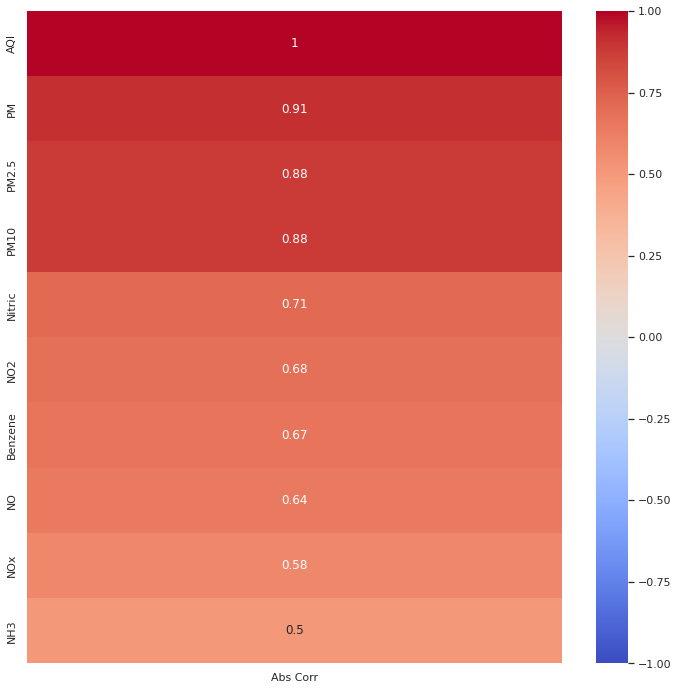

In [29]:
correlations = df_copy.corrwith(df_copy['AQI']).iloc[:].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.5], cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

In [30]:
X = df_copy.drop(['AQI', 'AQI_Bucket'], axis=1)
y = df_copy['AQI']

# Modelling 

In [31]:
len(X) * 70 / 100

1366.4

In [32]:
X_train = X.iloc[:1368]
X_test = X.iloc[1368:]
y_train = y.iloc[:1368]
y_test = y.iloc[1368:]

In [33]:
X_test

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,PM,Nitric,BTX
Date,,,,,,,,,,,,,,,
2018-11-24,107.73,223.33,26.91,46.57,50.88,36.97,1.34,15.12,37.48,3.33,30.31,0.99,331.06,124.36,34.63
2018-11-25,133.62,268.83,59.31,58.16,84.38,39.78,1.72,16.56,37.17,4.61,43.22,0.90,402.45,201.85,48.73
2018-11-26,200.69,362.41,94.45,68.30,120.55,47.15,2.43,20.11,39.80,7.01,61.96,2.34,563.10,283.30,71.31
2018-11-27,205.53,378.23,152.00,78.94,176.98,53.89,3.32,18.31,34.02,10.54,92.77,4.61,583.76,407.92,107.92
2018-11-28,193.10,356.12,120.37,69.60,146.11,53.87,2.85,15.96,34.61,8.67,73.80,2.44,549.22,336.08,84.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,39.80,155.94,10.88,21.46,22.47,31.43,0.87,10.38,18.88,1.69,19.99,0.43,195.74,54.81,22.11
2020-06-28,59.52,308.65,12.67,21.60,23.86,29.27,0.94,10.70,18.05,1.71,25.13,1.74,368.17,58.13,28.58
2020-06-29,44.86,184.12,10.50,21.57,21.94,27.97,0.88,11.58,26.61,2.13,23.80,1.13,228.98,54.01,27.06


In [34]:
y_train

Date
2015-01-01    472.0
2015-01-02    454.0
2015-01-03    143.0
2015-01-04    319.0
2015-01-05    325.0
              ...  
2018-11-19    340.0
2018-11-20    367.0
2018-11-21    396.0
2018-11-22    317.0
2018-11-23    356.0
Name: AQI, Length: 1368, dtype: float64

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [36]:
Scaler = StandardScaler()
scaled_X_train = Scaler.fit_transform(X_train)
scaled_X_test = Scaler.transform(X_test)

In [37]:
param_grid = {'C':[0.001,0.01,0.1,0.5,1],
             'kernel':['linear','rbf','poly'],
              'gamma':['scale','auto'],
              'degree':[2,3,4],
              'epsilon':[0,0.01,0.1,0.5,1,2]}
svr = SVR()
grid = GridSearchCV(svr,param_grid=param_grid)

In [38]:
grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1], 'degree': [2, 3, 4],
                         'epsilon': [0, 0.01, 0.1, 0.5, 1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [39]:
grid.best_params_

{'C': 1, 'degree': 2, 'epsilon': 0, 'gamma': 'scale', 'kernel': 'linear'}

In [40]:
model_predict=grid.predict(scaled_X_test)

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [42]:
mean_squared_error(model_predict, y_test)

1299.4021788135033

In [43]:
np.sqrt(mean_squared_error(y_test,model_predict))

36.047221513086185

In [44]:
r2_score(y_test, model_predict)

0.9032768618347559

In [ ]:
y_test